In [132]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

In [133]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])
train_data=datasets.MNIST(root="data",train=True,download=True,transform=transform)
test_data=datasets.MNIST(root="data",train=False,download=True,transform=transform)
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)
test_loader=DataLoader(test_data,batch_size=64,shuffle=False)

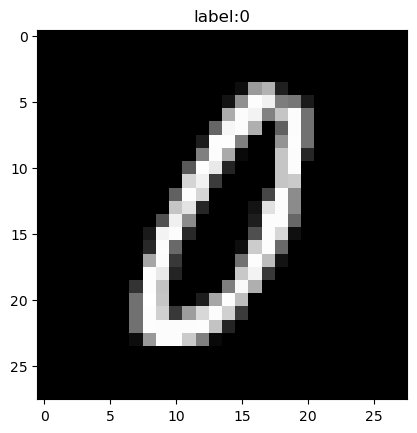

In [144]:
def imshow(img,labels):
    img=img*0.3081+0.1307
    plt.imshow(np.transpose(img[0],(1,2,0)),cmap="gray")
    plt.title(f"label:{labels[0].item()}")
    plt.show()

data=next(iter(train_loader))
imshow(data[0],data[1])



In [145]:
device=torch.device("cuda" if torch.cuda.is_available()else "cpu")
print(f"Using device:{device}")

Using device:cpu


In [146]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 14x14

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 7x7

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 10)  # Output for 10 digit classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x 


model = CNN()

In [147]:
model=model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [152]:
def train(model,train_loader,criterion,device):
   model.train()
   running_loss=0.0
   correct=0
   total=0
    
   for images,labels in train_loader:
      images,labels=images.to(device),labels.to(device)
      output=model(images)
      loss=criterion(output,labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step() 
      
      running_loss += loss.item()
      _, predicted = output.max(1)
      total += labels.size(0)         # Batch size
      correct += predicted.eq(labels).sum().item()  # Count correct predictions

   accuracy = 100. * correct / total
   avg_loss = running_loss / len(train_loader)
   print(f"Train Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%")
      


In [153]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.3f}, Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [150]:
num_epoch=5
for epoch in range(num_epoch):
    print(f"\Epoch [{epoch+1}/{num_epoch}]")
    train(model,train_loader,criterion,device)
    evaluate(model,test_loader,criterion,device)
    

\Epoch [1/5]
Train Loss: 0.293, Accuracy: 90.81%
Test Loss: 0.042, Test Accuracy: 98.62%
\Epoch [2/5]
Train Loss: 0.121, Accuracy: 96.42%
Test Loss: 0.031, Test Accuracy: 98.93%
\Epoch [3/5]
Train Loss: 0.086, Accuracy: 97.33%
Test Loss: 0.042, Test Accuracy: 98.51%
\Epoch [4/5]
Train Loss: 0.068, Accuracy: 97.90%
Test Loss: 0.033, Test Accuracy: 99.04%
\Epoch [5/5]
Train Loss: 0.057, Accuracy: 98.26%
Test Loss: 0.029, Test Accuracy: 99.17%


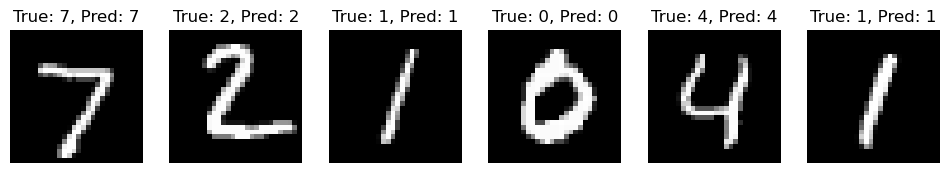

In [154]:
def show_predictions(model, test_loader, device, num_images=6):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for i in range(num_images):
        img = images[i].cpu().numpy().squeeze()
        img = img * 0.3081 + 0.1307  # Un-normalize
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
        axes[i].axis('off')
    plt.show()

show_predictions(model, test_loader, device)